In [870]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import rc, font_manager
ticks_font = font_manager.FontProperties(family='serif', style='normal',
                                         size=24, weight='normal', stretch='normal')
import scipy.integrate as integrate
import scipy.optimize as optimize
from scipy import interpolate

In [560]:
# Mo
inputdata = {
    "E_f_v" :2.96 ,
    "E_f_si" : 7.419 ,
    "a_0" : 3.14,
    "E_w" : 0.146,
    "G": 51,
    "nu": 0.3,
    "rho" : 4e13
}
experiment_conditions = {
    "T" : 300,
    "strain_r" : 0.001 
}

In [561]:
4e13/10**13

4.0

In [562]:
class Suzuki_model_RWASM:
    
    def __init__(self,
                inputdata,
                composition,
                experiment_conditions):
        
        # conditions
        self.strain_r = experiment_conditions['strain_r']
        self.T = experiment_conditions['T']
        # constants
        self.boltzmann_J = 1.380649e-23
        self.boltzmann_eV = 8.617333262145e-5
        self.kT = self.boltzmann_J * self.T
        self.J2eV = self.boltzmann_eV/self.boltzmann_J
        self.eV2J = 1/self.J2eV
        self.Debye = 5 * 10**(12) # Debye frequency /s
        self.rho = inputdata['rho']
        
        # properties
        self.E_f_v = inputdata['E_f_v'] * self.eV2J #J
        self.E_f_si = inputdata['E_f_si'] * self.eV2J # J
        self.a_0 = inputdata['a_0'] * 10**(-10) # unit: m
        self.E_w = inputdata['E_w'] * self.eV2J # J
        self.c = composition
        self.G = inputdata['G'] * 10**9 # Pa
        self.nu = 0.3
        
        self.b = self.a_0 * np.sqrt(3) / 2
        self.a_p = self.a_0 * np.sqrt(2/3)
        self.E_vac = 0.707 * self.E_f_v  /self.b + self.G * self.b**2 / (np.pi*(1-self.nu)) * np.log(1.5)
        self.E_int = 0.707 * self.E_f_si /self.b + self.G * self.b**2 / (np.pi*(1-self.nu)) * np.log(1.5)
        self.lambda_k = self.b * 10
        
        
        
    def L(self,kappa_i):
        f = lambda x: np.exp(-x**2/2)/np.sqrt(2*np.pi)
        y = integrate.quad(f,kappa_i,np.inf)
        return self.b/(3*y[0]*self.c) 
    

    
    
    def tau_y_optimize(self,x):
        
        self.tau_j = lambda kappa_i: (self.E_int + self.E_vac)/(4*self.b*self.L(kappa_i))
        
        self.Delta_V = lambda x: 3 * x[1]**2 * self.E_w**2 * self.c / (2*x[0]**2*self.a_p*self.b**2) + \
                                     x[0]**2 * self.a_p**3 * self.b**4 * self.lambda_k**2 / (6*x[1]**2 * self.E_w**2 * self.c)
        
        self.S = lambda x: 18 * x[1]**2 * self.E_w**2 * self.c *self.kT /(self.a_p**3 * self.b**4 * self.lambda_k**2) * \
                 np.log( (5*np.pi*self.kT)**2 * self.Debye * self.a_p * self.b /((self.G*self.b*self.Delta_V(x))**2 * self.strain_r) )
        
        self.R = lambda kappa_i: 27 * kappa_i**4 * self.E_w**4 * self.c**2 / (self.a_p**4 * self.b**6 * self.lambda_k**2)
        
        # x[0] = tau_k
        # x[1] = kappa_i
        #self.tau_k_opt_func = lambda x: x[0]**4 + x[0]*self.S(x) - self.R(x[1]) 
        
        self.tau_y_funcs = lambda x: (self.tau_j(x[1]) + x[0], x[0]**4 + x[0]*self.S(x) - self.R(x[1]))
        
        
        self.res = optimize.root(self.tau_y_funcs, x)
        
        self.tau_k_value = self.res.x[0]
        self.tau_y_value = (self.res.x[0]) + self.tau_j(self.res.x[1])
        self.tau_j_value = self.tau_j(self.res.x[1])
        self.L_value = self.L(self.res.x[1])

In [563]:
model = Suzuki_model_RWASM(inputdata,0.05,experiment_conditions)
print(model.E_w)
print(model.E_int)
print(model.E_vac)
print(model.a_p)
print(model.lambda_k)

model_results = []
tau_k_list = []
tau_j_list = []
tau_y_list = []
optimized_kappa = []
optimized_L = []
kappa_i_list = np.linspace(0.001,15,2000)
for kappa_i in kappa_i_list:
    x = np.array([5000000,kappa_i])
    model.tau_y_optimize(x)
    model_results.append(model.res)
    optimized_L.append(model.L_value)
    optimized_kappa.append(model.res.x[1])
    tau_k_list.append(model.tau_k_value/1e6)
    tau_j_list.append(model.tau_j_value/1e6)
    tau_y_list.append(model.tau_y_value/1e6)




2.339177885640048e-20
3.785740003883886e-09
1.9283333367329973e-09
2.5637992641130596e-10
2.7193197678831374e-09


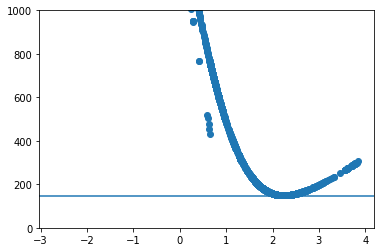

In [564]:
plt.scatter(optimized_kappa,tau_y_list)
plt.ylim(0,1000)
plt.axhline(144)

(0, 1000)

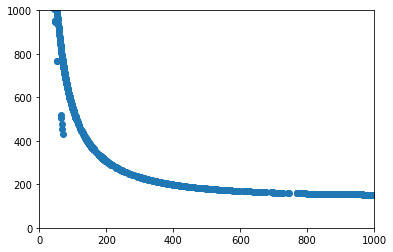

In [565]:
plt.scatter(np.array(optimized_L)*1e10,tau_y_list)
plt.ylim(0,1000)
plt.xlim(0,1000)

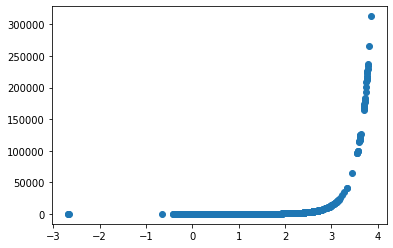

In [566]:
plt.scatter(optimized_kappa,np.array(optimized_L)*1e10)

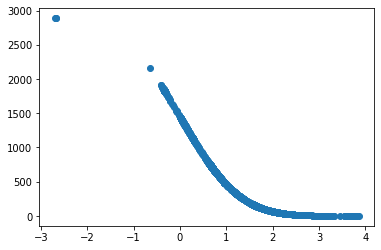

In [552]:
plt.scatter(optimized_kappa,tau_j_list)

In [559]:
# Nb
inputdata2 = {
    "E_f_v" :2.99 ,
    "E_f_si" : 5.254 ,
    "a_0" : 3.3,
    "E_w" : 0.07,
    "G": 51,
    "nu": 0.3,
    "rho" : 4e13
}
experiment_conditions = {
    "T" : 300,
    "strain_r" : 0.001 
}

In [575]:

model2 = Suzuki_model_RWASM(inputdata2,0.9,experiment_conditions)
print(model2.E_w)
print(model2.E_int)
print(model2.E_vac)
print(model2.a_p)
print(model2.lambda_k)

model_results2 = []
tau_k_list2 = []
tau_j_list2 = []
tau_y_list2 = []
optimized_kappa2 = []
optimized_L2 = []
kappa_i_list2 = np.linspace(0.001,15,2000)
for kappa_i in kappa_i_list2:
    x = np.array([5000000,kappa_i])
    model2.tau_y_optimize(x)
    model_results2.append(model2.res)
    optimized_L2.append(model2.L_value)
    optimized_kappa2.append(model2.res.x[1])
    tau_k_list2.append(model2.tau_k_value/1e6)
    tau_j_list2.append(model2.tau_j_value/1e6)
    tau_y_list2.append(model2.tau_y_value/1e6)


plt.scatter(optimized_kappa2,tau_y_list2)
plt.ylim(0,1000)
plt.axhline(620)


1.1215236438000231e-20
2.8504599574078905e-09
1.953110388574753e-09
2.694438717061496e-10
2.8578838324886473e-09


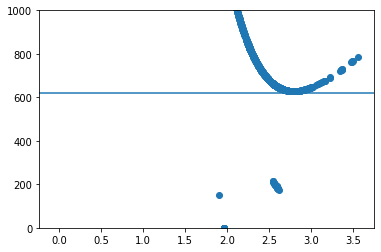

In [580]:
plt.scatter(optimized_kappa2,tau_y_list2)
plt.ylim(0,1000)
plt.axhline(620)

In [586]:
def tau_Nb(para):
    (theta_i,q) = para
    return (theta_i*0.95**q-650, theta_i*0.90**q-625)


In [593]:
optimize.root(tau_Nb,[700,1])

    fjac: array([[-0.72105266, -0.69288027],
       [ 0.69288027, -0.72105266]])
     fun: array([-1.75077730e-11, -2.78532752e-11])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.83245929e-07, 7.05717035e-08])
       r: array([-1.33491592, 69.71361662, 24.39217258])
  status: 1
 success: True
       x: array([674.64110386,   0.72540649])

In [594]:
def tau_Mo(para):
    (theta_i,q) = para
    return (theta_i*0.05**q-145, theta_i*0.1**q-280)

optimize.root(tau_Mo,[600,1])

    fjac: array([[-0.45183103, -0.89210354],
       [ 0.89210354, -0.45183103]])
     fun: array([-1.36708422e-11, -1.50066626e-11])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([-2.25937990e-08,  6.04265705e-09])
       r: array([-1.22385098e-01,  7.57166345e+02, -9.22836582e+01])
  status: 1
 success: True
       x: array([2.49190774e+03, 9.49373927e-01])

In [596]:
q = 0.9
(145*(1/q) + 650**(1/q))**q

720.1945181252473

In [961]:
# Ti
inputdataTi = {
    "E_f_v" :2.99 ,
    "E_f_si" : 5.254 ,
    "a_0" : 3.31,
    "E_w" : -0.028,
    "G": 32,
    "nu": 0.35,
    "rho" : 4e13
}
experiment_conditions = {
    "T" : 300,
    "strain_r" : 0.001 
}

# Nb
inputdataNb = {
    "E_f_v" :2.99 ,
    "E_f_si" : 5.254 ,
    "a_0" : 3.3,
    "E_w" : 0.054,
    "G": 32,
    "nu": 0.35,
    "rho" : 4e13
}
experiment_conditions = {
    "T" : 300,
    "strain_r" : 0.001 
}

# Zr
inputdataZr = {
    "E_f_v" :2.99 ,
    "E_f_si" : 5.254 ,
    "a_0" : 3.58,
    "E_w" : -0.053,
    "G": 32,
    "nu": 0.35,
    "rho" : 4e13
}
experiment_conditions = {
    "T" : 300,
    "strain_r" : 0.001 
}




In [962]:
class Suzuki_model_RWASM_NbTiZr:
    
    def __init__(self,
                inputdata,
                composition,
                experiment_conditions):
        
        # conditions
        self.strain_r = experiment_conditions['strain_r']
        self.T = experiment_conditions['T']
        # constants
        self.boltzmann_J = 1.380649e-23
        self.boltzmann_eV = 8.617333262145e-5
        self.kT = self.boltzmann_J * self.T
        self.J2eV = self.boltzmann_eV/self.boltzmann_J
        self.eV2J = 1/self.J2eV
        self.Debye = 5 * 10**(12) # Debye frequency /s
        self.rho = inputdata['rho']
        
        # properties
        self.E_f_v = inputdata['E_f_v'] * self.eV2J #J
        self.E_f_si = inputdata['E_f_si'] * self.eV2J # J
        self.a_0 = 3.397*1e-10#inputdata['a_0'] * 10**(-10) # unit: m
        self.E_w = 0.05 * self.eV2J#inputdata['E_w'] * self.eV2J # J
        self.c = composition
        self.G = inputdata['G'] * 10**9 # Pa
        self.nu = 0.3
        
        self.b = self.a_0 * np.sqrt(3) / 2
        self.a_p = self.a_0 * np.sqrt(2/3)
        #self.E_vac = 0.6 * self.eV2J / 10**(-10) #
        #self.E_int = 0.9 * self.eV2J / 10**(-10) #
        self.E_vac = 0.707 * self.E_f_v  /self.b + self.G * self.b**2 / (np.pi*(1-self.nu)) * np.log(1.5)
        self.E_int = 0.707 * self.E_f_si /self.b + self.G * self.b**2 / (np.pi*(1-self.nu)) * np.log(1.5)
        self.lambda_k = self.b * 10
        
        
        
    def L(self,kappa_i):
        f = lambda x: np.exp(-x**2/2)/np.sqrt(2*np.pi)
        y = integrate.quad(f,kappa_i,np.inf)
        return self.b/(3*y[0]*self.c) 
    
    def tau_y_optimize(self,x):
        
        self.tau_j = lambda kappa_i: (self.E_int + self.E_vac)/(4*self.b*self.L(kappa_i))
        
        self.Delta_V = lambda x: 3 * x[1]**2 * self.E_w**2 * self.c / (2*x[0]**2*self.a_p*self.b**2) + \
                                     x[0]**2 * self.a_p**3 * self.b**4 * self.lambda_k**2 / (6*x[1]**2 * self.E_w**2 * self.c)
        
        self.S = lambda x: 18 * x[1]**2 * self.E_w**2 * self.c *self.kT /(self.a_p**3 * self.b**4 * self.lambda_k**2) * \
                 np.log( (5*np.pi*self.kT)**2 * self.Debye * self.a_p * self.b /((self.G*self.b*self.Delta_V(x))**2 * self.strain_r) )
        
        self.R = lambda kappa_i: 27 * kappa_i**4 * self.E_w**4 * self.c**2 / (self.a_p**4 * self.b**6 * self.lambda_k**2)
        
        # x[0] = tau_k
        # x[1] = kappa_i
        #self.tau_k_opt_func = lambda x: x[0]**4 + x[0]*self.S(x) - self.R(x[1]) 
        
        self.tau_y_funcs = lambda x: (self.tau_j(x[1]) + x[0], x[0]**4 + x[0]*self.S(x) - self.R(x[1]))
        
        
        self.res = optimize.root(self.tau_y_funcs, x)
        
        self.tau_k_value = self.res.x[0]
        self.tau_y_value = (self.res.x[0]) + self.tau_j(self.res.x[1])
        self.tau_j_value = self.tau_j(self.res.x[1])
        self.L_value = self.L(self.res.x[1])
        
        

In [965]:
experiment_conditions['T'] = 300
experiment_conditions

{'T': 300, 'strain_r': 0.001}

8.010883170000164e-21
1.4419589706000296e-09
9.613059804000197e-10
2.773638885411485e-10
2.9418882966557377e-09
8.010883170000164e-21
1.4419589706000296e-09
9.613059804000197e-10
2.773638885411485e-10
2.9418882966557377e-09
8.010883170000164e-21
1.4419589706000296e-09
9.613059804000197e-10
2.773638885411485e-10
2.9418882966557377e-09


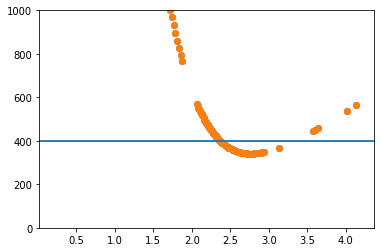

In [966]:

modelNb = Suzuki_model_RWASM_NbTiZr(inputdataNb,1,experiment_conditions)
print(modelNb.E_w)
print(modelNb.E_int)
print(modelNb.E_vac)
print(modelNb.a_p)
print(modelNb.lambda_k)

model_resultsNb = []
tau_k_listNb = []
tau_j_listNb = []
tau_y_listNb = []
optimized_kappaNb = []
optimized_LNb = []
kappa_i_listNb = np.linspace(1,5,200)
for kappa_i in kappa_i_listNb:
    x = np.array([5000000,kappa_i])
    modelNb.tau_y_optimize(x)
    model_resultsNb.append(modelNb.res)
    optimized_LNb.append(modelNb.L_value)
    optimized_kappaNb.append(modelNb.res.x[1])
    tau_k_listNb.append(modelNb.tau_k_value/1e6)
    tau_j_listNb.append(modelNb.tau_j_value/1e6)
    tau_y_listNb.append(modelNb.tau_y_value/1e6)


plt.scatter(optimized_kappaNb,tau_y_listNb)
plt.ylim(0,1000)
plt.axhline(400)


modelTi = Suzuki_model_RWASM_NbTiZr(inputdataTi,1,experiment_conditions)
print(modelTi.E_w)
print(modelTi.E_int)
print(modelTi.E_vac)
print(modelTi.a_p)
print(modelTi.lambda_k)

model_resultsTi = []
tau_k_listTi = []
tau_j_listTi = []
tau_y_listTi = []
optimized_kappaTi = []
optimized_LTi = []
kappa_i_listTi = np.linspace(1,5,200)
for kappa_i in kappa_i_listTi:
    x = np.array([5000000,kappa_i])
    modelTi.tau_y_optimize(x)
    model_resultsTi.append(modelTi.res)
    optimized_LTi.append(modelTi.L_value)
    optimized_kappaTi.append(modelTi.res.x[1])
    tau_k_listTi.append(modelTi.tau_k_value/1e6)
    tau_j_listTi.append(modelTi.tau_j_value/1e6)
    tau_y_listTi.append(modelTi.tau_y_value/1e6)


plt.scatter(optimized_kappaTi,tau_y_listTi)
plt.ylim(0,1000)
plt.axhline(400)



modelZr = Suzuki_model_RWASM_NbTiZr(inputdataZr,1,experiment_conditions)
print(modelZr.E_w)
print(modelZr.E_int)
print(modelZr.E_vac)
print(modelZr.a_p)
print(modelZr.lambda_k)

model_resultsZr = []
tau_k_listZr = []
tau_j_listZr = []
tau_y_listZr = []
optimized_kappaZr = []
optimized_LZr = []
kappa_i_listZr = np.linspace(1,5,200)
for kappa_i in kappa_i_listZr:
    x = np.array([5000000,kappa_i])
    modelZr.tau_y_optimize(x)
    model_resultsZr.append(modelZr.res)
    optimized_LZr.append(modelZr.L_value)
    optimized_kappaZr.append(modelZr.res.x[1])
    tau_k_listZr.append(modelZr.tau_k_value/1e6)
    tau_j_listZr.append(modelZr.tau_j_value/1e6)
    tau_y_listZr.append(modelZr.tau_y_value/1e6)




341.14240379775055

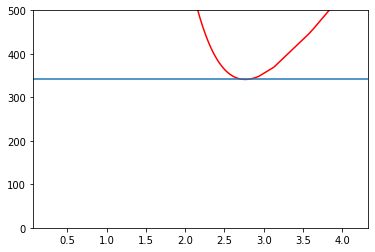

In [967]:
new_coords_x, new_coords_y  = zip(*sorted(zip(optimized_kappaZr, tau_y_listZr)))

x_array = np.linspace(0,4,200)
plt.plot(new_coords_x,new_coords_y,color='r')
plt.ylim(0,500)
plt.axhline(min(new_coords_y))
min(new_coords_y)

In [971]:
np.log(2)

0.6931471805599453

(0, 500)

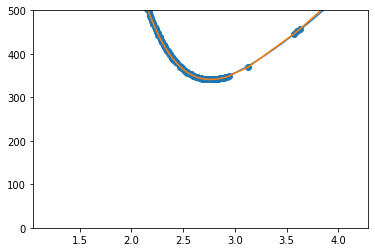

In [968]:
new_x = new_coords_x[next(i for i,v in enumerate(new_coords_x) if v > 1):]
new_y = new_coords_y[next(i for i,v in enumerate(new_coords_x) if v > 1):]
polyfit = np.polyfit(new_x,new_y,5)
npfit = np.poly1d(polyfit)

fit = interpolate.interp1d(new_x,new_y)
x_array = np.arange(min(new_x),max(new_x),0.001)

plt.scatter(new_x,new_y)
plt.plot(x_array,npfit(x_array))
plt.plot(x_array,fit(x_array))
plt.ylim(0,500)


In [973]:
guess_kappa = (min(new_x)+max(new_x))/2
print(guess_kappa)
res = optimize.fmin_slsqp(npfit,guess_kappa,bounds=([(min(new_x),max(new_x))]))

2.6675525112756935
Optimization terminated successfully    (Exit mode 0)
            Current function value: [341.39207031]
            Iterations: 4
            Function evaluations: 10
            Gradient evaluations: 4


In [978]:
npfit(res[0])

341.3920703070853

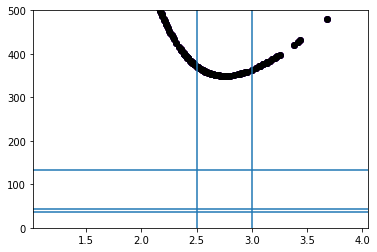

In [933]:
plt.scatter(optimized_kappaNb,tau_y_listNb,color='r')
#plt.ylim(0,200)
plt.axhline(134)

plt.scatter(optimized_kappaZr,tau_y_listZr,color='b')
#plt.ylim(0,200)
plt.axhline(44)

plt.scatter(optimized_kappaTi,tau_y_listTi,color='k')
plt.ylim(0,500)
plt.axhline(36)

plt.axvline(3)
plt.axvline(2.5)

In [827]:
# universal 0.05 eV E_w
q = 1
# 300K
print((134**(1/q) + (110)**(1/q) + (134)**(1/q))**q * 2.75)
# 673 
print(((74)**(1/q) + (59)**(1/q) + (74)**(1/q))**q * 2.75)
# 873
print(((59)**(1/q) + (48)**(1/q) + (59)**(1/q))**q * 2.75)
# 1073 
print(((51)**(1/q) + (41)**(1/q) + (51)**(1/q))**q * 2.75)
# 1273 
print(((44)**(1/q) + (36)**(1/q) + (44)**(1/q))**q * 2.75)

1039.5
569.25
456.5
393.25
341.0


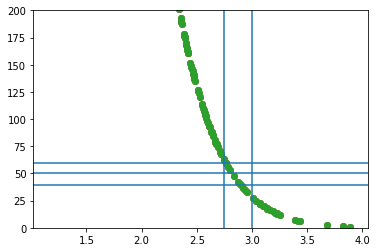

In [937]:
plt.scatter(optimized_kappaNb,tau_j_listNb)
#plt.ylim(0,200)
plt.axhline(50)

plt.scatter(optimized_kappaZr,tau_j_listZr)
#plt.ylim(0,200)
plt.axhline(39)

plt.scatter(optimized_kappaTi,tau_j_listTi)
plt.ylim(0,200)
plt.axhline(60)

plt.axvline(3)
plt.axvline(2.74440486)

In [922]:
# different E_w for Ti, Nb, and Zr
q = 0.95
# 300K
print((153**(1/q) + (120)**(1/q) + (56)**(1/q))**q * 2.75)
# 673 
print(((82)**(1/q) + (64)**(1/q) + (30)**(1/q))**q * 2.75)
# 873
print(((67)**(1/q) + (53)**(1/q) + (24)**(1/q))**q * 2.75)
# 1073 
print(((57)**(1/q) + (45)**(1/q) + (20)**(1/q))**q * 2.75)
# 1273 
print(((50)**(1/q) + (39)**(1/q) + (18)**(1/q))**q * 2.75)

859.6776709328013
459.8891621187227
376.32692528169827
318.87625984499516
279.62142012882214


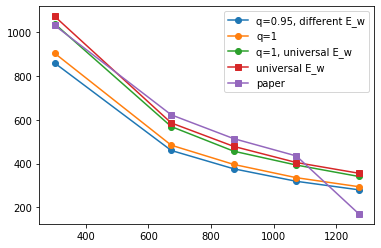

In [960]:
paper_data = [
1032.146606445312,
622.820007324219,
513.924377441406,
434.880462646484,
169.899871826172,
]
predicted_data1 = [860,460,376,319,280]
predicted_data2 = [904.75,484.0,396.0,335.5,294.25]
predicted_data3 = [1039.5,569.25,456.5,393.25,341.0]
predicted_data4 = np.array([350,191,156,132, 116])*3.067
plt.plot([300,673,873,1073,1273],predicted_data1,'-o',label='q=0.95, different E_w')
plt.plot([300,673,873,1073,1273],predicted_data2,'-o',label='q=1')
plt.plot([300,673,873,1073,1273],predicted_data3,'-o',label='q=1, universal E_w')
plt.plot([300,673,873,1073,1273],predicted_data4,'-s',label='universal E_w')



plt.plot([300,673,873,1073,1273],paper_data,'-s',label='paper')
plt.legend()

In [714]:
class Suzuki_model_RWASM_NbTiZr_high_T:
    
    def __init__(self,
                inputdata,
                composition,
                experiment_conditions):
        
        # conditions
        self.strain_r = experiment_conditions['strain_r']
        self.T = experiment_conditions['T']
        # constants
        self.boltzmann_J = 1.380649e-23
        self.boltzmann_eV = 8.617333262145e-5
        self.kT = self.boltzmann_J * self.T
        self.J2eV = self.boltzmann_eV/self.boltzmann_J
        self.eV2J = 1/self.J2eV
        self.Debye = 5 * 10**(12) # Debye frequency /s
        self.rho = inputdata['rho']
        
        # properties
        self.E_f_v = inputdata['E_f_v'] * self.eV2J #J
        self.E_f_si = inputdata['E_f_si'] * self.eV2J # J
        self.a_0 = inputdata['a_0'] * 10**(-10) # unit: m
        self.E_w = inputdata['E_w'] * self.eV2J # J
        self.c = composition
        self.G = inputdata['G'] * 10**9 # Pa
        self.nu = 0.3
        
        self.b = self.a_0 * np.sqrt(3) / 2
        self.a_p = self.a_0 * np.sqrt(2/3)
        self.E_vac = 0.6 * self.eV2J / 10**(-10) #0.707 * self.E_f_v  /self.b + self.G * self.b**2 / (np.pi*(1-self.nu)) * np.log(1.5)
        self.E_int = 0.9 * self.eV2J / 10**(-10) #0.707 * self.E_f_si /self.b + self.G * self.b**2 / (np.pi*(1-self.nu)) * np.log(1.5)
        self.lambda_k = self.b * 10
        
        self.Tl = 1961
        self.Q = 19.12 * self.boltzmann_J * self.Tl
        self.D = 14 * self.Debye * self.b **2 * np.exp(-self.Q/self.kT)
        
        
    def L(self,kappa_i):
        f = lambda x: np.exp(-x**2/2)/np.sqrt(2*np.pi)
        y = integrate.quad(f,kappa_i,np.inf)
        return self.b/(3*y[0]*self.c) 
    

    
    
    def tau_y_optimize(self,x):
        
        self.tau_j = lambda kappa_i: (self.kT / (b**2 *2 * self.L(kappa_i))) * \
                                     np.log(self.strain_r/(2.598*np.pi*self.rho*self.D) + (1+(self.strain_r/(2.598*np.pi*self.rho*self.D))**2)**(0.5))
        
        self.Delta_V = lambda x: 3 * x[1]**2 * self.E_w**2 * self.c / (2*x[0]**2*self.a_p*self.b**2) + \
                                     x[0]**2 * self.a_p**3 * self.b**4 * self.lambda_k**2 / (6*x[1]**2 * self.E_w**2 * self.c)
        
        self.S = lambda x: 18 * x[1]**2 * self.E_w**2 * self.c *self.kT /(self.a_p**3 * self.b**4 * self.lambda_k**2) * \
                 np.log( (5*np.pi*self.kT)**2 * self.Debye * self.a_p * self.b /((self.G*self.b*self.Delta_V(x))**2 * self.strain_r) )
        
        self.R = lambda kappa_i: 27 * kappa_i**4 * self.E_w**4 * self.c**2 / (self.a_p**4 * self.b**6 * self.lambda_k**2)
        
        # x[0] = tau_k
        # x[1] = kappa_i
        #self.tau_k_opt_func = lambda x: x[0]**4 + x[0]*self.S(x) - self.R(x[1]) 
        
        self.tau_y_funcs = lambda x: (self.tau_j(x[1]) + x[0], x[0]**4 + x[0]*self.S(x) - self.R(x[1]))
        
        
        self.res = optimize.root(self.tau_y_funcs, x)
        
        self.tau_k_value = self.res.x[0]
        self.tau_y_value = (self.res.x[0]) + self.tau_j(self.res.x[1])
        self.tau_j_value = self.tau_j(self.res.x[1])
        self.L_value = self.L(self.res.x[1])

In [715]:

modelNb = Suzuki_model_RWASM_NbTiZr_high_T(inputdataNb,0.33,experiment_conditions)
print(modelNb.E_w)
print(modelNb.E_int)
print(modelNb.E_vac)
print(modelNb.a_p)
print(modelNb.lambda_k)

model_resultsNb = []
tau_k_listNb = []
tau_j_listNb = []
tau_y_listNb = []
optimized_kappaNb = []
optimized_LNb = []
kappa_i_listNb = np.linspace(0.001,15,2000)
for kappa_i in kappa_i_listNb:
    x = np.array([5000000,kappa_i])
    modelNb.tau_y_optimize(x)
    model_resultsNb.append(modelNb.res)
    optimized_LNb.append(modelNb.L_value)
    optimized_kappaNb.append(modelNb.res.x[1])
    tau_k_listNb.append(modelNb.tau_k_value/1e6)
    tau_j_listNb.append(modelNb.tau_j_value/1e6)
    tau_y_listNb.append(modelNb.tau_y_value/1e6)




8.651753823600177e-21
1.4419589706000296e-09
9.613059804000197e-10
2.694438717061496e-10
2.8578838324886473e-09


In [716]:

modelTi = Suzuki_model_RWASM_NbTiZr_high_T(inputdataTi,0.33,experiment_conditions)
print(modelTi.E_w)
print(modelTi.E_int)
print(modelTi.E_vac)
print(modelTi.a_p)
print(modelTi.lambda_k)

model_resultsTi = []
tau_k_listTi = []
tau_j_listTi = []
tau_y_listTi = []
optimized_kappaTi = []
optimized_LTi = []
kappa_i_listTi = np.linspace(0.001,15,2000)
for kappa_i in kappa_i_listTi:
    x = np.array([5000000,kappa_i])
    modelTi.tau_y_optimize(x)
    model_resultsTi.append(modelTi.res)
    optimized_LTi.append(modelTi.L_value)
    optimized_kappaTi.append(modelTi.res.x[1])
    tau_k_listTi.append(modelTi.tau_k_value/1e6)
    tau_j_listTi.append(modelTi.tau_j_value/1e6)
    tau_y_listTi.append(modelTi.tau_y_value/1e6)





-4.486094575200092e-21
1.4419589706000296e-09
9.613059804000197e-10
2.7026036828707733e-10
2.8665440865264917e-09


 /opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning:divide by zero encountered in double_scalars


In [717]:

modelZr = Suzuki_model_RWASM_NbTiZr_high_T(inputdataZr,0.33,experiment_conditions)
print(modelZr.E_w)
print(modelZr.E_int)
print(modelZr.E_vac)
print(modelZr.a_p)
print(modelZr.lambda_k)

model_resultsZr = []
tau_k_listZr = []
tau_j_listZr = []
tau_y_listZr = []
optimized_kappaZr = []
optimized_LZr = []
kappa_i_listZr = np.linspace(0.001,15,2000)
for kappa_i in kappa_i_listZr:
    x = np.array([5000000,kappa_i])
    modelZr.tau_y_optimize(x)
    model_resultsZr.append(modelZr.res)
    optimized_LZr.append(modelZr.L_value)
    optimized_kappaZr.append(modelZr.res.x[1])
    tau_k_listZr.append(modelZr.tau_k_value/1e6)
    tau_j_listZr.append(modelZr.tau_j_value/1e6)
    tau_y_listZr.append(modelZr.tau_y_value/1e6)




-8.491536160200174e-21
1.4419589706000296e-09
9.613059804000197e-10
2.923057759721259e-10
3.10037094554829e-09


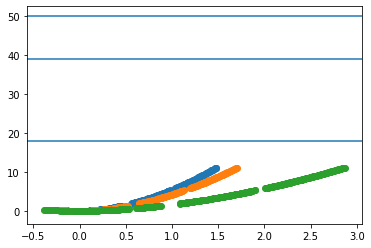

In [720]:
plt.scatter(optimized_kappaNb,tau_y_listNb)
#plt.ylim(0,200)
plt.axhline(50)

plt.scatter(optimized_kappaZr,tau_y_listZr)
#plt.ylim(0,200)
plt.axhline(39)

plt.scatter(optimized_kappaTi,tau_y_listTi)
#plt.ylim(0,100)
plt.axhline(18)

In [722]:
modelNb.kT, modelNb.Q, modelNb.rho*modelNb.D

(1.757566177e-20, 5.176649541368001e-19, 3.69615099727667e-05)